## Is it possible to predict star ratings on Yelp?

This project focuses on whether business attributes like availabilty of parking, table service or reservations can be used to predict the star rating of a business on the Yelp website.

The data comes from the Yelp Open Data Set which contains 150,346 businesses with over 1.2 million attributes: https://www.yelp.com/dataset.

After cleaning the data I will apply different machine learning models to find the right estimator.

### Data Cleaning

In [258]:
import pandas as pd
import json
import re
import numpy as np

In [259]:
# Some of the nested objects like 'BusinessParking' are wronlgy stored 
# with additional quotation marks around them. The quotes need to be removed
# so that the object can be correcly turned into a flat table.

data = []

with open('yelp_dataset/yelp_academic_dataset_business.json') as f:

    for line in f:
        json_dict = json.loads(line)

        if json_dict['attributes']:
            if 'BusinessParking' in json_dict['attributes'].keys():
                json_dict['attributes']['BusinessParking'] = eval(json_dict['attributes']['BusinessParking'])

        data.append(json_dict)

In [260]:
businesses = pd.json_normalize(data)

In [261]:
# Make column names lowercase and seperate words with underscore

businesses.columns = businesses.columns.str.split(('.')).str[-1]

columns = []

for column in businesses.columns:
    column = re.sub(r'(\w)([A-Z])', r'\1_\2', column)
    column = re.sub(r'Restaurants_', r'', column)
    column = re.sub(r'Business_', r'', column)
    column = re.sub(r'(Range)([0-9])', r'\1', column)
    columns.append(column.lower())

businesses.columns = columns

In [262]:
# Some attribute columns have too many missing values. We will get rid of them and also drop some other columns which we are not interested in.

businesses[businesses.columns[13:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 52 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   by_appointment_only    42339 non-null   object 
 1   accepts_credit_cards   119765 non-null  object 
 2   monday                 114474 non-null  object 
 3   tuesday                120631 non-null  object 
 4   wednesday              123771 non-null  object 
 5   thursday               125198 non-null  object 
 6   friday                 124999 non-null  object 
 7   saturday               110770 non-null  object 
 8   bike_parking           72638 non-null   object 
 9   price_range            85314 non-null   object 
 10  coat_check             5584 non-null    object 
 11  take_out               59857 non-null   object 
 12  delivery               56282 non-null   object 
 13  caters                 40127 non-null   object 
 14  wi_fi                  56914 non-nul

In [263]:
businesses.drop(
  [
    'attributes',
    'hair_specializes_in',
    'counter_service',
    'open24_hours',
    'dietary_restrictions',
    'accepts_insurance',
    'ages_allowed',
    'b_yo_bcorkage',
    'corkage',
    'smoking',
    'b_yo_b',
    'good_for_dancing',
    'coat_check',
    'by_appointment_only',
    'best_nights',
    'music',
    'drive_thru',
    'accepts_bitcoin',
    'dogs_allowed',
    'happy_hour',
    'wheelchair_accessible',
    'good_for_meal',
    'ambience',
    'business_parking',
    'address',
    'postal_code',
    'hours',
    'is_open',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    'sunday',
    'latitude',
    'longitude'
  ],
  axis=1, errors='ignore', inplace=True)

In [264]:
# Remove u'...' prefix from values

businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']] = businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']].apply(lambda x: x.str.strip("u'"), axis=0)

In [265]:
# Parking availability has different categories which are stored in separate columns.
# Instead we want to summarize in a new column wheather parking in general is available or not.

def check_parking(row):
    if True in row.values:
        return 'True'
    elif False in row.values:
        return 'False'
    else:
        return np.nan
    
businesses['parking'] = businesses[['garage', 'street', 'validated', 'lot', 'valet']].apply(check_parking, axis=1)

businesses.drop(['garage', 'street','validated','lot','valet'], axis=1, inplace=True)

### Exploring the data

In [266]:
# What are the top 20 business categories use by businesses in the data set?

from collections import Counter

businesses_categories = []

for labels in businesses['categories'].str.split(', '):
    if labels is not None:
        for label in labels:
            businesses_categories.append(label)

category_count = Counter(businesses_categories).most_common(20)

In [267]:
import matplotlib.pyplot as plt

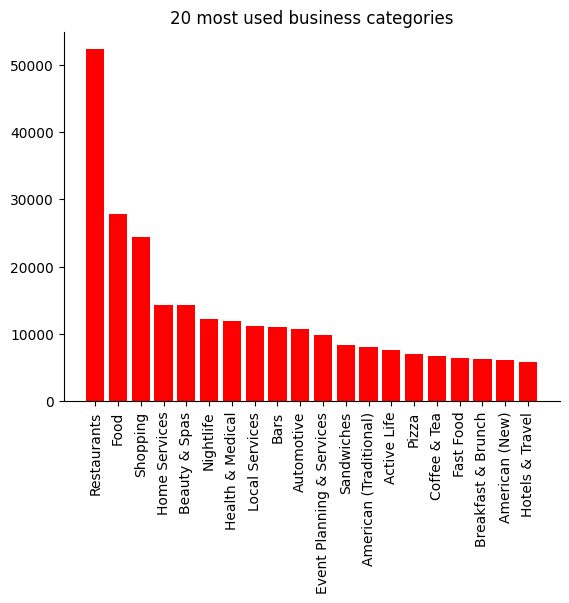

In [268]:
x = [i[0] for i in category_count]
y = [i[1] for i in category_count]

plt.bar(x, y, color='r')
plt.title('20 most used business categories')
plt.xticks(rotation=90)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show();

### Restaurants

In [269]:
businesses.dropna(subset='categories', inplace=True)
businesses.reset_index(drop=True, inplace=True)

In [270]:
def get_restaurants(row):
    if 'Restaurants' in row:
        return True

In [271]:
restaurants = businesses[businesses['categories'].apply(get_restaurants) == True]

In [272]:
restaurants

,business_id,name,city,state,stars,review_count,categories,accepts_credit_cards,bike_parking,price_range,...,outdoor_seating,has_tv,reservations,alcohol,good_for_kids,parking,attire,table_service,good_for_groups,noise_level
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",False,True,1,...,False,NaN,NaN,none,NaN,True,NaN,NaN,NaN,NaN
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,TN,2.0,6,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",True,False,1,...,True,True,False,none,True,NaN,casual,False,True,NaN
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,Affton,MO,3.0,19,"Pubs, Restaurants, Italian, Bars, American (Tr...",True,NaN,1,...,True,True,False,full_bar,True,True,casual,NaN,True,average
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,Nashville,TN,1.5,10,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",True,NaN,1,...,True,True,False,none,True,False,casual,False,False,NaN
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa Bay,FL,4.0,10,"Vietnamese, Food, Restaurants, Food Trucks",NaN,NaN,NaN,...,None,NaN,False,none,NaN,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150222,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,Clifton Heights,PA,3.0,11,"Restaurants, Sandwiches, Convenience Stores, C...",True,True,1,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
150224,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,Boise,ID,4.0,33,"Cafes, Juice Bars & Smoothies, Coffee & Tea, R...",True,True,1,...,True,False,False,none,True,True,casual,NaN,True,loud
150233,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,Philadelphia,PA,4.5,35,"Restaurants, Mexican",True,True,2,...,False,True,False,none,True,True,casual,True,True,NaN
150236,2O2K6SXPWv56amqxCECd4w,The Plum Pit,Aston,DE,4.5,14,"Restaurants, Comfort Food, Food, Food Trucks, ...",True,True,1,...,NaN,NaN,NaN,none,NaN,True,NaN,NaN,NaN,NaN


In [230]:
restaurants = businesses[businesses['categories'].apply(check_categories) == True]

In [231]:
restaurants.reset_index(drop=True, inplace=True)

In [232]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54918 entries, 0 to 54917
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   business_id           54918 non-null  object 
 1   name                  54918 non-null  object 
 2   city                  54918 non-null  object 
 3   state                 54918 non-null  object 
 4   stars                 54918 non-null  float64
 5   review_count          54918 non-null  int64  
 6   categories            54918 non-null  object 
 7   accepts_credit_cards  47744 non-null  object 
 8   bike_parking          37392 non-null  object 
 9   price_range           46658 non-null  object 
 10  take_out              50816 non-null  object 
 11  delivery              49015 non-null  object 
 12  caters                35814 non-null  object 
 13  wi_fi                 39948 non-null  object 
 14  outdoor_seating       45656 non-null  object 
 15  has_tv             

In [167]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54918 entries, 3 to 150237
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   business_id           54918 non-null  object 
 1   name                  54918 non-null  object 
 2   city                  54918 non-null  object 
 3   state                 54918 non-null  object 
 4   stars                 54918 non-null  float64
 5   review_count          54918 non-null  int64  
 6   categories            54918 non-null  object 
 7   accepts_credit_cards  47744 non-null  object 
 8   bike_parking          37392 non-null  object 
 9   price_range           46658 non-null  object 
 10  take_out              50816 non-null  object 
 11  delivery              49015 non-null  object 
 12  caters                35814 non-null  object 
 13  wi_fi                 39948 non-null  object 
 14  outdoor_seating       45656 non-null  object 
 15  has_tv                4

### Attributes

In [277]:
cols = ['price_range', 'attire', 'wi_fi', 'noise_level', 'alcohol']

for label in cols:
    print (restaurants[label].value_counts(), '\n')

price_range
2       29478
1       24398
3        2257
4         292
None       19
Name: count, dtype: int64 

attire
casual    38257
dressy      802
formal       70
None         38
Name: count, dtype: int64 

wi_fi
free    23903
no      18590
paid      292
None       37
Name: count, dtype: int64 

noise_level
average      25942
quiet         7448
loud          2802
very_loud     1097
None            39
Name: count, dtype: int64 

alcohol
none             20764
full_bar         15650
beer_and_wine     6176
None                38
Name: count, dtype: int64 



In [278]:
cols = ['price_range', 'attire', 'wi_fi', 'noise_level', 'alcohol']

for label in cols:
    restaurants.loc[restaurants[label] == 'None', label] = np.nan

In [279]:
restaurants = restaurants[restaurants[restaurants.columns[9:]].isna().any(axis=1) == False].replace(['none', 'None'], ['False', 'False'])

In [280]:
restaurants['alcohol'].replace(['False', 'beer_and_wine', 'full_bar'], [0, 1, 2], inplace=True)
restaurants['attire'].replace(['casual', 'dressy', 'formal'], [0, 1, 2], inplace=True)
restaurants['wi_fi'].replace(['no', 'paid', 'free'], [0, 1, 2], inplace=True)
restaurants['noise_level'].replace(['quiet', 'average', 'loud', 'very_loud'], [0, 1, 2, 3], inplace=True)

In [281]:
cols = [
    'accepts_credit_cards',
    'bike_parking', 'take_out', 'delivery', 'caters',
    'outdoor_seating', 'has_tv', 'reservations',
    'good_for_kids', 'parking', 'table_service',
    'good_for_groups']

for label in cols:
    restaurants[label] = (restaurants[label] == 'True').astype(int)  # Encodes True as 1, False as 0

In [282]:
restaurants['price_range'] = restaurants['price_range'].astype(int)
restaurants['stars'] = restaurants['stars'].astype(int)

In [283]:
cols = restaurants.columns[9:].to_list()
cols.append('stars')
cols

['accepts_credit_cards',
 'bike_parking',
 'price_range',
 'take_out',
 'delivery',
 'caters',
 'wi_fi',
 'outdoor_seating',
 'has_tv',
 'reservations',
 'alcohol',
 'good_for_kids',
 'parking',
 'attire',
 'table_service',
 'good_for_groups',
 'noise_level',
 'stars']

In [285]:
# import seaborn as sns

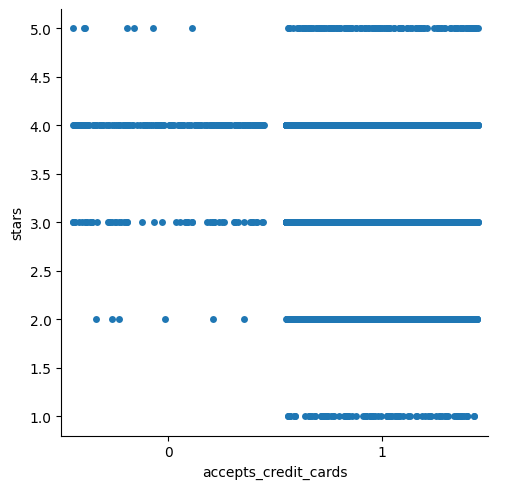

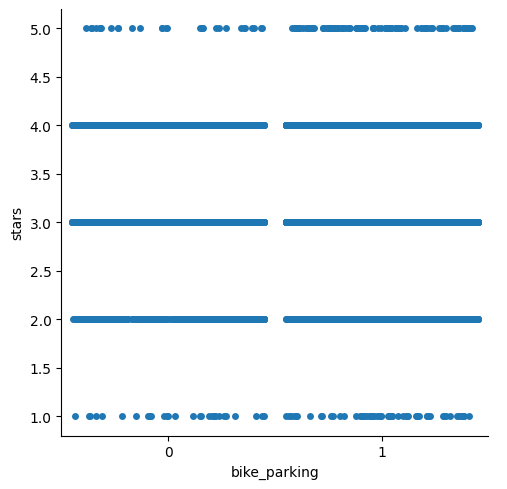

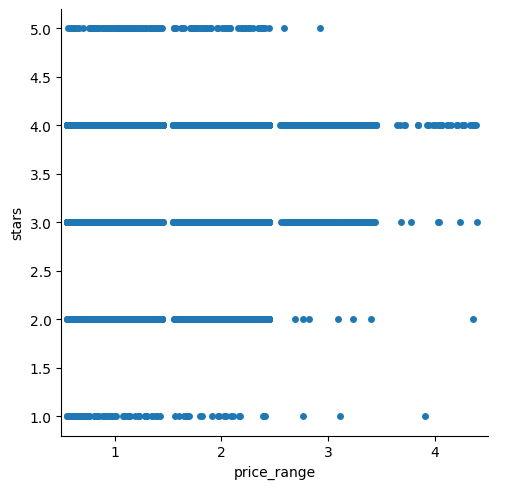

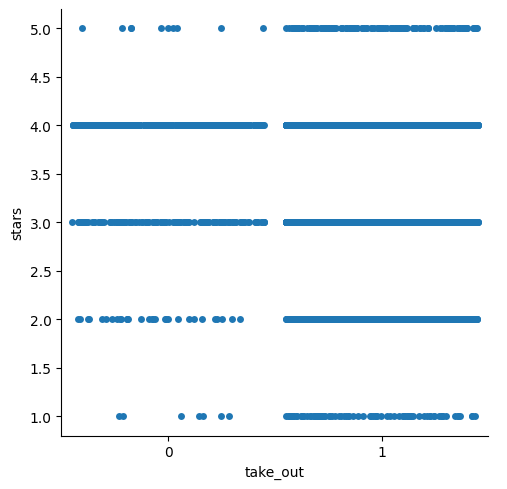

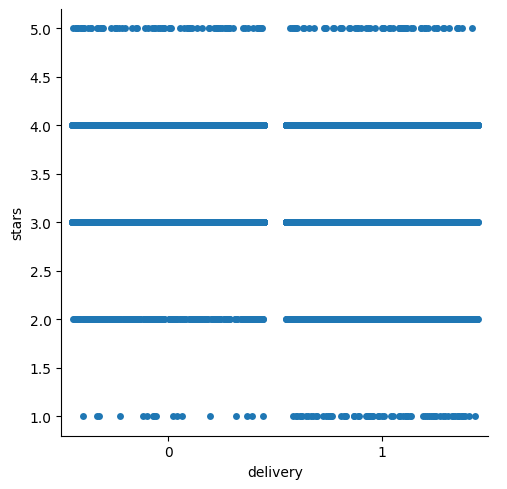

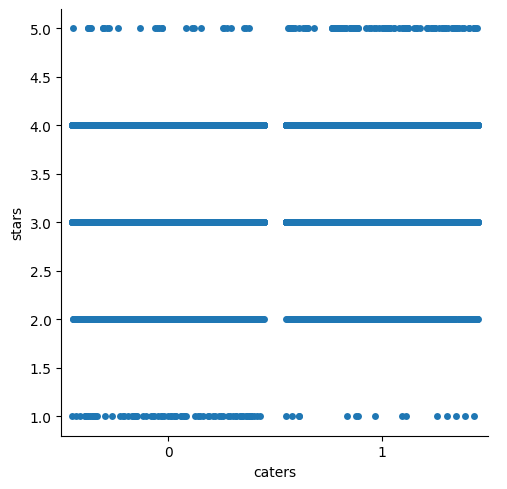

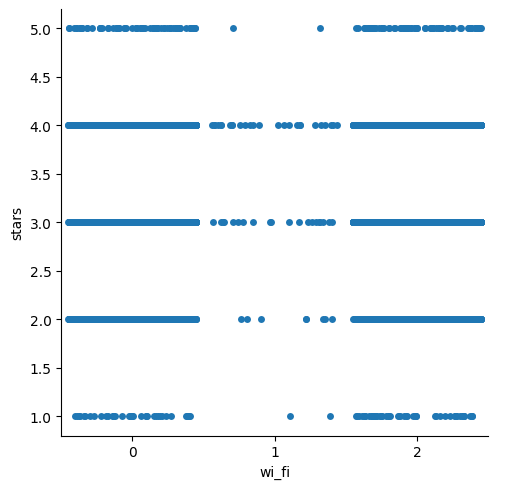

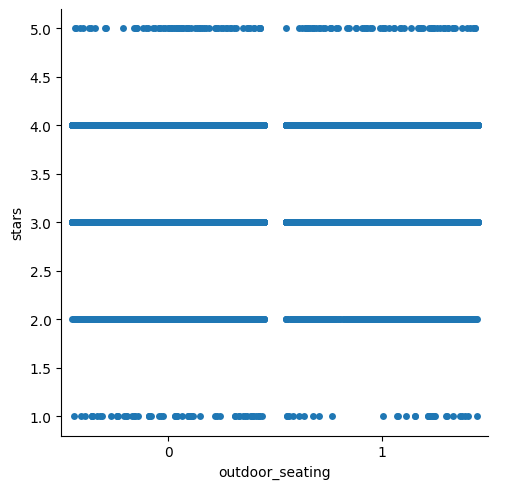

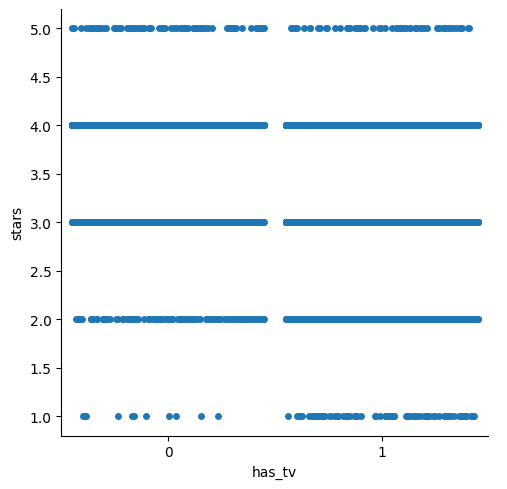

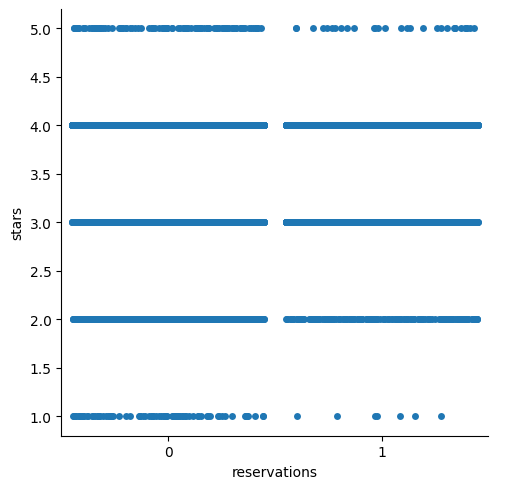

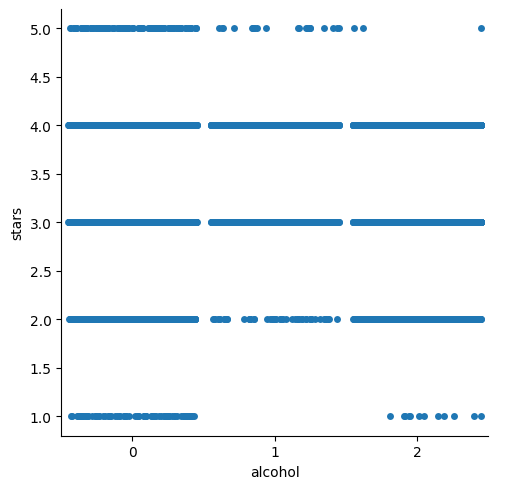

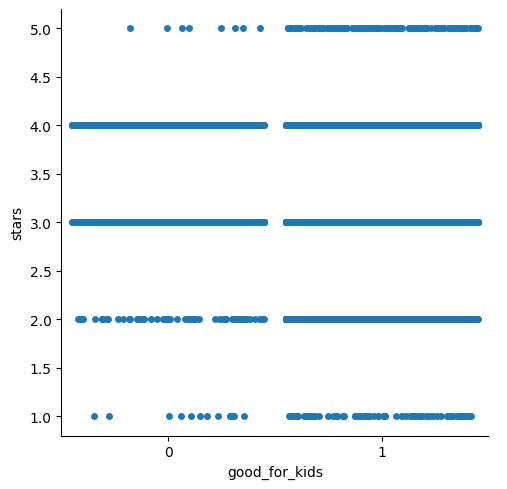

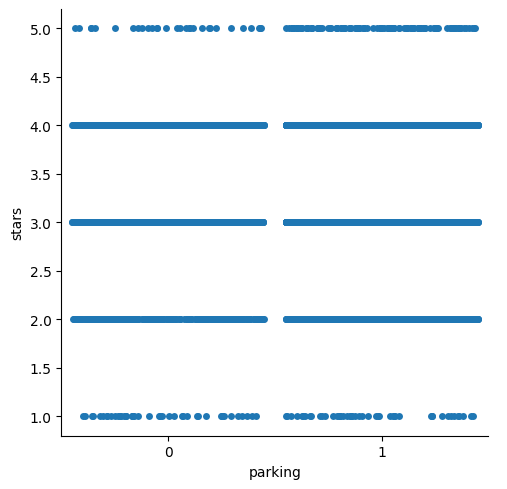

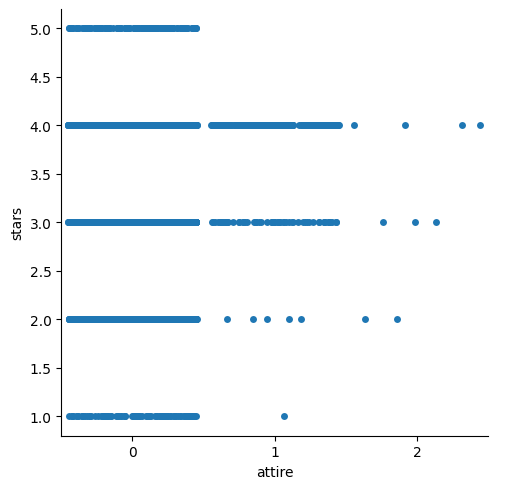

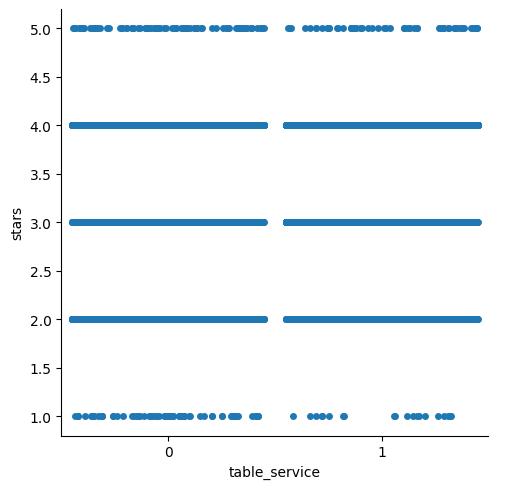

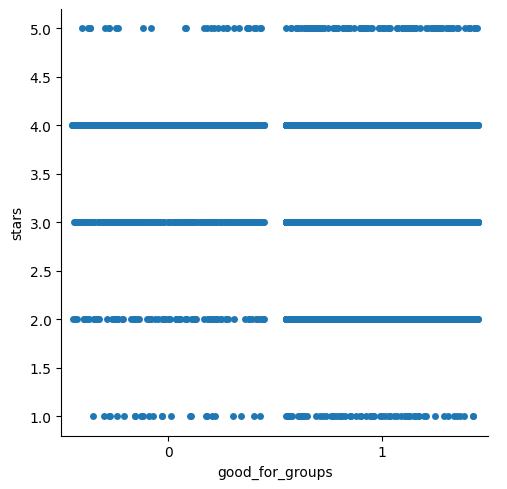

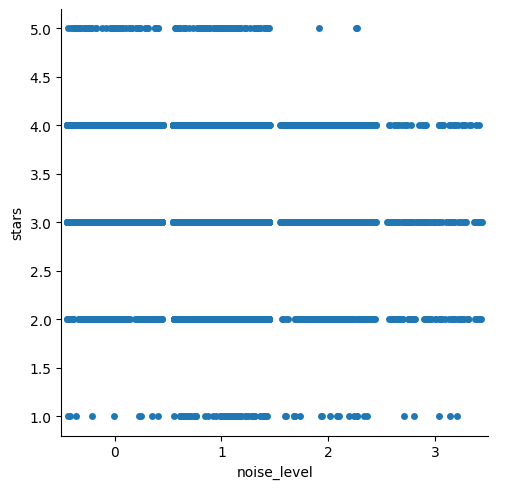

In [286]:
# for label in restaurants.columns[9:]:
#     sns.catplot(restaurants, x=label, y='stars', jitter=0.45)
#     sns.despine();

In [152]:
restaurants = restaurants[restaurants['stars'] != 5]

In [287]:
restaurants['stars'].value_counts()

stars
4    6509
3    4280
2     907
5     141
1      90
Name: count, dtype: int64

In [76]:
# CHI2

In [77]:
from sklearn.feature_selection import chi2

In [288]:
X = restaurants[restaurants.columns[9:]]
y = restaurants['stars']

In [156]:
chi_scores = chi2(X,y)

In [157]:
chi_scores

(array([  0.84032373,  25.44333468,  20.94643036,   2.96946994,
         40.93368315,  93.76100478,   4.10510862,  26.87023463,
        100.71022027, 126.42227216, 188.85569921,   9.32947212,
         43.27354166,  25.77913984,  79.1886302 ,   8.91586694,
         71.6495262 ]),
 array([8.39799780e-01, 1.24720456e-05, 1.08007657e-04, 3.96356303e-01,
        6.75444737e-09, 3.40853453e-20, 2.50335695e-01, 6.26790611e-06,
        1.09340290e-21, 3.19153545e-27, 1.07843185e-40, 2.52164314e-02,
        2.15293213e-09, 1.06087892e-05, 4.58208267e-17, 3.04306496e-02,
        1.89229607e-15]))

In [158]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

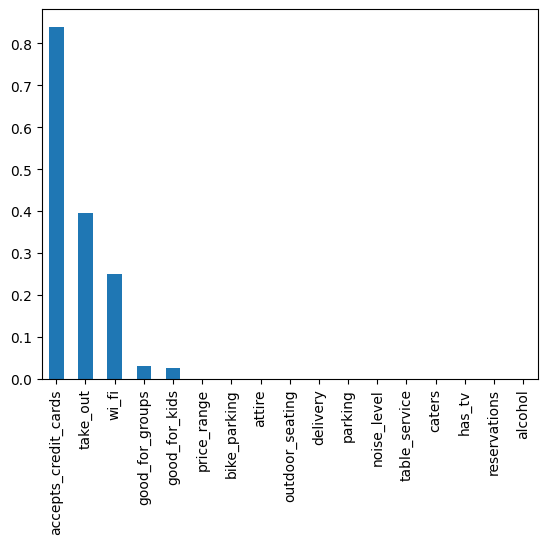

In [159]:
p_values.plot.bar();

In [83]:
from sklearn.feature_selection import f_classif

In [160]:
anova = f_classif(X, y)

In [161]:
anova

(array([ 13.08786332,  38.72205473,  42.50040508,  19.90015479,
         34.2840573 ,  85.07633702,   1.69407682,  19.91428268,
        138.32896822,  72.18096868,  77.71186319,  22.15673933,
        126.47635353,   8.23667197,  84.49228058,  33.5371263 ,
         87.59523955]),
 array([1.57434421e-08, 6.83045755e-25, 2.61789652e-27, 7.32656809e-13,
        4.71198294e-22, 1.87050922e-54, 1.65936281e-01, 7.17615680e-13,
        4.38461716e-88, 2.97144843e-46, 8.97375339e-50, 2.66188541e-14,
        1.23789845e-80, 1.79667177e-05, 4.39486610e-54, 1.41569411e-21,
        4.70424237e-56]))

In [162]:
p_values = pd.Series(anova[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

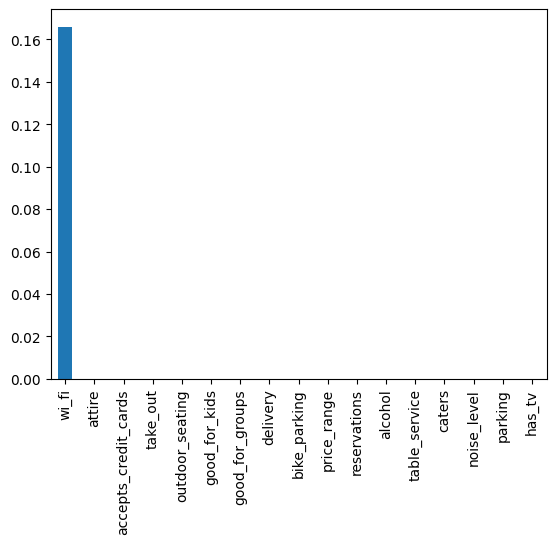

In [163]:
p_values.plot.bar();

In [216]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler()
X, y = ros.fit_resample(X, y)

In [289]:
train, valid, test = np.split(restaurants.sample(frac=1), [int(0.6*len(restaurants)), int(0.8*len(restaurants))])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [290]:
def split_X_y(dataframe, oversample=False):
    X = dataframe[dataframe.columns[9:]]
    y = dataframe['stars']

    # if oversample:
    #     ros = RandomOverSampler()
    #     X, y = ros.fit_resample(X, y)

    return X, y

In [291]:
X_train, y_train = split_X_y(train, oversample=False)
X_test, y_test = split_X_y(test, oversample=False)

In [292]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [293]:
clf_gaussian = GaussianNB()
clf_gaussian.fit(X_train, y_train)

GaussianNB()

In [294]:
y_pred = clf_gaussian.predict(X_test)

In [295]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.04      0.57      0.08        21
           2       0.10      0.01      0.02       185
           3       0.46      0.43      0.44       858
           4       0.68      0.12      0.21      1289
           5       0.03      0.85      0.05        33

    accuracy                           0.24      2386
   macro avg       0.26      0.40      0.16      2386
weighted avg       0.54      0.24      0.27      2386



In [296]:
from sklearn.naive_bayes import CategoricalNB

In [297]:
clf_categorical = CategoricalNB()
clf_categorical.fit(X_train, y_train)

CategoricalNB()

In [298]:
y_pred = clf_categorical.predict(X_test)

In [299]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.11      0.19      0.14        21
           2       0.28      0.15      0.19       185
           3       0.48      0.40      0.43       858
           4       0.62      0.71      0.66      1289
           5       0.08      0.12      0.10        33

    accuracy                           0.54      2386
   macro avg       0.31      0.31      0.30      2386
weighted avg       0.53      0.54      0.53      2386



In [300]:
from sklearn.linear_model import LogisticRegression

In [301]:
lg_model = LogisticRegression(multi_class='multinomial')
lg_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [302]:
y_pred  = lg_model.predict(X_test)

In [303]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.47      0.12      0.20       185
           3       0.47      0.31      0.37       858
           4       0.60      0.82      0.69      1289
           5       0.00      0.00      0.00        33

    accuracy                           0.56      2386
   macro avg       0.31      0.25      0.25      2386
weighted avg       0.53      0.56      0.52      2386



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [304]:
from sklearn.neighbors import KNeighborsClassifier

In [305]:
neigh = KNeighborsClassifier()
neigh.fit(X, y)

KNeighborsClassifier()

In [306]:
y_pred = neigh.predict(X_test)

In [307]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.29      0.19      0.23        21
           2       0.49      0.39      0.43       185
           3       0.54      0.59      0.56       858
           4       0.70      0.70      0.70      1289
           5       0.00      0.00      0.00        33

    accuracy                           0.62      2386
   macro avg       0.40      0.37      0.38      2386
weighted avg       0.61      0.62      0.62      2386



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [181]:
import tensorflow as tf

In [182]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation= 'relu', input_shape=(17,)),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [183]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs=100,  # epoch = training cycle
    batch_size=32,
    validation_split=0.2  # ??Uses some part of the data to validate the model
)

Epoch 1/100
177/177 [==============================] - 2s 6ms/step - loss: -109.4839 - accuracy: 0.0071 - val_loss: -458.2971 - val_accuracy: 0.0064
Epoch 2/100
177/177 [==============================] - 1s 4ms/step - loss: -1978.3447 - accuracy: 0.0071 - val_loss: -4465.3408 - val_accuracy: 0.0064
Epoch 3/100
177/177 [==============================] - 1s 5ms/step - loss: -9488.2188 - accuracy: 0.0071 - val_loss: -16193.8447 - val_accuracy: 0.0064
Epoch 4/100
177/177 [==============================] - 1s 5ms/step - loss: -26795.3887 - accuracy: 0.0071 - val_loss: -39703.9102 - val_accuracy: 0.0064
Epoch 5/100
177/177 [==============================] - 1s 4ms/step - loss: -57319.0898 - accuracy: 0.0071 - val_loss: -77712.0938 - val_accuracy: 0.0064
Epoch 6/100
177/177 [==============================] - 1s 5ms/step - loss: -103850.1641 - accuracy: 0.0071 - val_loss: -133249.6562 - val_accuracy: 0.0064
Epoch 7/100
177/177 [==============================] - 1s 4ms/step - loss: -168938.2500

In [184]:
def plot_loss(history):

    fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(10, 4))

    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Binary crossentropy')
    ax2.grid(True)

    plt.show()

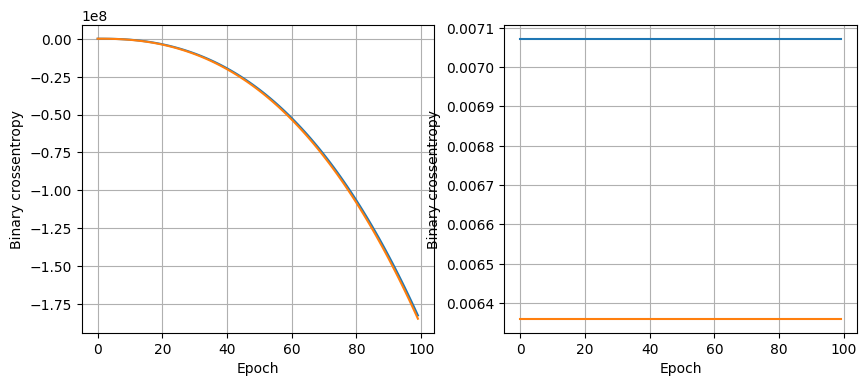

In [185]:
plot_loss(history)

In [ ]:
for label in restaurants.columns[9:]:
    display(pd.crosstab(restaurants[label][restaurants[label].notna()], restaurants['stars'][restaurants[label].notna()], margins=True, normalize='columns'))

In [ ]:
from sklearn.feature_selection import f_regression

In [ ]:
data_table_service = restaurants[['table_service', 'stars']][restaurants['table_service'].notna()]

In [ ]:
data_table_service

In [ ]:
data_table_service['table_service'] = (data_table_service['table_service'] == 'True').astype(int)

In [ ]:
X = np.reshape(data_table_service['table_service'], (-1, 1))
y = data_table_service['stars']

In [ ]:
y

In [ ]:
data_table_service['stars']

In [ ]:
f_statistic, p_values = f_regression(X, y)

In [ ]:
f_statistic

In [ ]:
for i in range(len(f_statistic)):
    print(f"Feature {i + 1}: F-statistic = {f_statistic[i]}, P-value = {p_values[i]}")

In [ ]:
with open('tables/restaurants_pennsylvania.csv', 'w') as f:
    restaurants.to_csv(f, header=True, index=False)

### We have created a table with all restaurants in Pennsylvania and saved it in a .csv for later analysis

### Now we load the table with all reviews and create a .csv which only contains reviews from restaurants in Pennsylvania

In [ ]:
businesses_ids = restaurants['business_id'].to_list()

column_names = ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

chunks = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

with open('tables/reviews_pennsylvania.csv', 'w') as f:
    header = ','.join(column_names)
    f.write(header + '\n')

    for chunk in chunks:
        reviews = pd.DataFrame(chunk)
        
        reviews[reviews['business_id'].isin(businesses_ids)].to_csv(f, mode='a', header=False, index=False)

### Analysis starts here

In [ ]:
restaurants = get_file('tables/restaurants_pennsylvania.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))

# fig.suptitle('Customer ratings', fontsize=16)

sns.barplot(
    ax = ax,
    x=restaurants['stars'].value_counts().sort_index().index,
    y=restaurants['stars'].value_counts().sort_index().values*100/restaurants['stars'].value_counts().sort_index().values.sum(),
    color='#FF1A1A'
)
ax.set(xlabel='Stars', ylabel='No. of businesses in %')
ax.set_title('Star ratings');

In [ ]:
restaurants[[
    'stars',
    'accepts_credit_cards',
    'bike_parking',
    'price_range',
    'take_out',
    'delivery',
    'caters',
    'wi_fi',
    'outdoor_seating',
    'has_tv',
    'reservations',
    'alcohol',
    'good_for_kids',
    'attire',
    'table_service',
    'good_for_groups',
    'noise_level',
    'parking_available'
]].corr(method='spearman')

In [ ]:
reviews = get_file('tables/reviews_pennsylvania.csv')

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')

def check_polarity(text):
    doc = nlp(text)
    return doc._.blob.polarity

reviews['polarity'] = reviews['text'][:10000].apply(lambda x: check_polarity(x))

In [ ]:
with open('tables/reviews_polarity.csv', 'w') as f:
    reviews[:10000].to_csv(f, header=True, index=False)

In [ ]:
reviews = get_file('tables/reviews_polarity.csv')

In [ ]:
negative_reviews = reviews[reviews['polarity'] < 0]

### Analys negative reviews

#### We want to find statements about food

In [ ]:
# Training the entity rule to recognize food

food = pd.read_csv('food_labels/food.csv')

In [ ]:
food_labels = food[food['description'].str.contains('[a-zA-Z]') == True]['description']

In [ ]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [ ]:
food_labels = food_labels.str.lower()

In [ ]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [ ]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [ ]:
# If label has no plural, create singular form. If label has no singular, create plural 

import spacy
import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [ ]:
food_labels_inflected = pd.Series(inflected_labels)

In [ ]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [ ]:
food_labels.drop_duplicates(inplace=True)

In [ ]:
food_labels[food_labels.str.contains('bar', regex=True)]

In [ ]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [ ]:
len(patterns)

In [ ]:
ruler.to_disk('food_labels/food_patterns.jsonl')

In [ ]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", before='ner')

ruler.from_disk('food_labels/food_patterns.jsonl')